<a href="https://colab.research.google.com/github/lrodrigocareaga/thesis/blob/master/MosquitoHybridModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import keras,os,tarfile,sys,pickle,zipfile

#Keras libraries & packages
from keras import models,initializers,layers,optimizers
from keras import backend as K
from keras.utils import to_categorical,plot_model
from keras.models import Sequential,Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D,advanced_activations,Flatten,concatenate,Dropout,MaxPooling2D,Activation,GlobalAveragePooling2D,BatchNormalization,SeparableConv2D,SpatialDropout2D,LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

#Sci-kit libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold, ShuffleSplit
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, MultiLabelBinarizer, LabelEncoder
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_regression

#Others
import time
import matplotlib.image as mpimg
import warnings
import skimage
import argparse
import locale
import glob
import sklearn.model_selection
import cv2
import shapely.wkt
import shapely.affinity
import seaborn as sns
from skimage.io import imshow
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads

Using TensorFlow backend.


In [2]:
# Establish the home directory
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/mosquito')

Mounted at /content/drive/


In [3]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://7dc43f9c.ngrok.io


In [0]:
warnings.filterwarnings('ignore')

In [0]:
def avg(lst): 
    return sum(lst) / len(lst) 

# Experiments

## Load Data


In [0]:
def loadData(fileXls):

  #Numerical and Categorical columns needed in the data
  cols = ['collection_date','GPS_lat','GPS_lon','species','day','month','year','sample_count']

  #Source file
  df_info = pd.read_excel(fileXls)
  #Erase blank rows
  df_info = df_info.dropna()

  #Add year and month
  df_info['year'] = df_info['collection_date'].dt.year.astype(int)
  df_info['month'] = df_info['collection_date'].dt.month.astype(int)
  df_info['day'] = df_info['collection_date'].dt.day.astype(int)

  #filter the dataset
  df = df_info[cols]
  df = df.dropna()

  df['GENUS'] = df['species'].str.split(' ').str[0].astype(str)
  df['SPECIES'] = df['species'].str.split(' ').str[1].astype(str)
  df = df.rename(columns={"GPS_lat": "LATITUDE", "GPS_lon": "LONGITUDE"})

  df.sample_count = df.sample_count.astype(int)
  df['date'] = pd.to_datetime(df['collection_date'].dt.strftime('%d-%m-%Y'))

  del df['collection_date']
  del df['species']

  return df

In [0]:
fileXls = '/content/drive/My Drive/mosquito/washington.xlsx'
#fileXls = '/content/drive/My Drive/mosquito/Manatee.xlsx'
#fileXls = '/content/drive/My Drive/mosquito/Hernando.xlsx'
df = loadData(fileXls)

In [0]:
#Count of mosquitos trapped by ovitrap
def printInfo(df):
  countMonthK = df["month"].value_counts().keys().tolist()
  countMonth = df["month"].value_counts().tolist()
  print('Number of mosquitos captured by Month: ' + str(countMonthK))
  print('Number of mosquitos captured by Month: ' + str(countMonth))

  countYearK = df["year"].value_counts().keys().tolist()
  countYear = df["year"].value_counts().tolist()
  print('Number of mosquitos captured by Year: ' + str(countYearK))
  print('Number of mosquitos captured by Year: ' + str(countYear))

  countGenusK = df["GENUS"].value_counts().keys().tolist()
  countGenus = df["GENUS"].value_counts().tolist()
  print('Number of mosquitos captured by Genus: ' + str(countGenusK))
  print('Number of mosquitos captured by Genus: ' + str(countGenus))

  #DataFrame of number of mosquitos by trap
  traps_df = pd.DataFrame({'Genus' : countGenusK,
                         'Total' : countGenus},
                         columns=['Genus','Total'])

  print(traps_df.head())
  return 

In [0]:
#dataset of Washington Climate
def loadDataClimate(fileXlsClimate):

  df_climate = pd.read_excel(fileXlsClimate)

  df_climate['LATITUDE'] = df_climate['coordinates'].str.split(';').str[0].astype(float)
  df_climate['LONGITUDE'] = df_climate['coordinates'].str.split(';').str[1].astype(float)
  
  df_climate['date'] =  pd.to_datetime(df_climate['date'], format='%Y-%m-%d')
  df_climate['year'] = df_climate['date'].dt.year.astype(int)
  df_climate['month'] = df_climate['date'].dt.month.astype(int)
  df_climate['day'] = df_climate['date'].dt.day.astype(int)
  
  return df_climate


In [0]:
fileXlsClimate = '/content/drive/My Drive/mosquito/weatherWashington.xlsx'
#fileXlsClimate = '/content/drive/My Drive/mosquito/WeatherManateeFinal.xlsx'
#fileXlsClimate = '/content/drive/My Drive/mosquito/WeatherHernando.xlsx'
df_climate = loadDataClimate(fileXlsClimate)

In [0]:
#Merge of climate and mosquitos dataset
def mergeDatasets(df, df_climate):
  result = pd.merge(df, df_climate, how='inner', on=['year','month','day','LATITUDE','LONGITUDE'])
  result.head()

  #Export dataset to csv
  del result['date_x']
  del result['coordinates']
  result = result.rename(columns={"sample_count": "TOTAL", "date_y": "date"}) 
  result.TOTAL = result.TOTAL.astype(int)
  result.to_csv('result.csv',index=True)

  return result

In [12]:
result = mergeDatasets(df, df_climate)
print(result.head())
print(result.info())

    LATITUDE  LONGITUDE  day  ...  humidity  windSpeed  cloudCover
0  38.921453 -77.014480    6  ...      0.52       1.50        0.15
1  38.914005 -77.057311    6  ...      0.51       1.41        0.16
2  38.938009 -76.958136    7  ...      0.74       1.63        0.74
3  38.873100 -76.972813    7  ...      0.74       1.59        0.75
4  38.921453 -77.014480   13  ...      0.46       0.68        0.03

[5 rows x 20 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 2022
Data columns (total 20 columns):
LATITUDE              2023 non-null float64
LONGITUDE             2023 non-null float64
day                   2023 non-null int64
month                 2023 non-null int64
year                  2023 non-null int64
TOTAL                 2023 non-null int64
GENUS                 2023 non-null object
SPECIES               2023 non-null object
date                  2023 non-null datetime64[ns]
precipType            2023 non-null int64
precipProbability     2023 non-nu

## Take Outliers

In [0]:
def takeOutliers(result, percentile):
  result  = result.sort_values(by=['TOTAL'])
  numEntries = len(result.index)
  lowerBound = round(((1-percentile)/2),3)
  upperBound = 1-lowerBound
  print(lowerBound,' and ',upperBound)
  result = result.iloc[int((numEntries*lowerBound)):(int(numEntries*upperBound))]
  result.reindex(np.random.permutation(result.index))
  return result

In [0]:
result = takeOutliers(result, 0.7)
print(result.head())
print(result.info())

0.15  and  0.85
        LATITUDE  LONGITUDE  day  ...  humidity  windSpeed  cloudCover
57690  27.564967 -82.424886    9  ...      0.92       1.02        0.60
3462   27.475085 -82.551283   24  ...      0.82       1.62        0.10
51063  27.603067 -82.535717   18  ...      0.82       2.50        0.32
3463   27.475085 -82.551283   24  ...      0.82       1.62        0.10
58573  27.591467 -82.199850   20  ...      0.80       0.83        0.10

[5 rows x 19 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45033 entries, 57690 to 13076
Data columns (total 19 columns):
LATITUDE              45033 non-null float64
LONGITUDE             45033 non-null float64
day                   45033 non-null int64
month                 45033 non-null int64
year                  45033 non-null int64
TOTAL                 45033 non-null int64
GENUS                 45033 non-null object
SPECIES               45033 non-null object
precipType            45033 non-null int64
precipProbability     45033 n

In [0]:
printInfo(result)

Number of mosquitos captured by Month: [8, 7, 6, 9, 10, 5, 11, 4, 12, 3, 2, 1]
Number of mosquitos captured by Month: [11109, 10999, 10842, 10429, 9985, 5500, 3564, 960, 636, 271, 26, 11]
Number of mosquitos captured by Year: [2014, 2013, 2016, 2015, 2012]
Number of mosquitos captured by Year: [14741, 13081, 12847, 12815, 10848]
Number of mosquitos captured by Genus: ['Culex', 'Aedes', 'Anopheles', 'Psorophora', 'Mansonia', 'Coquillettidia', 'Uranotaenia', 'Culiseta', 'Wyeomyia', 'BLANK', 'Culicidae', 'Culicinae', 'Orthopodomyia']
Number of mosquitos captured by Genus: [22134, 12108, 11349, 9557, 5542, 1605, 1251, 519, 108, 78, 72, 6, 3]
        Genus  Total
0       Culex  22134
1       Aedes  12108
2   Anopheles  11349
3  Psorophora   9557
4    Mansonia   5542


## Data Split

In [0]:
def xyFunc(result):
  del result['date']

  X = result.iloc[:, :].values
  y = result.iloc[:, 5].values

  # Transform categorical variables if needed
  labelencoder = LabelEncoder()
  X[:, 6] = labelencoder.fit_transform(X[:, 6])
  X[:, 7] = labelencoder.fit_transform(X[:, 7])
  #X[:, -1] = labelencoder.fit_transform(X[:, -1])
  scaler = MinMaxScaler(feature_range=(0, 1))
  X = scaler.fit_transform(X)
  #y = y/max(y)

  return X,y

In [0]:
X,y = xyFunc(result)

In [15]:
max(y)

696

## Visualization

In [0]:
def boxPlotFunc(result):
  sns.boxplot(x='GENUS',y='TOTAL',data=result)
  plt.xlabel('GENUS')
  plt.ylabel('TOTAL')
  plt.title('Boxplot Graph')
  plt.tight_layout()
  plt.xticks(rotation='vertical')
  plt.figure(figsize=(15, 20))
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/box_Overall_Year.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
def violinPlotFunc(result):
  sns.violinplot(x='GENUS',y='TOTAL',data=result,inner=None,color='lightgray')
  sns.stripplot(x='GENUS',y='TOTAL',data=result,size=10,jitter=True)
  plt.xlabel('GENUS')
  plt.ylabel('TOTAL')
  plt.title('Violin Graph')
  plt.xticks(rotation='vertical')
  plt.tight_layout()
  plt.figure(figsize=(15, 20))
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/viol_Overall_Year.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
#Observe the correlation of the variables
def corrPlotFunc(result):
  corr = result.corr()
  corr.style.background_gradient()
  plt.figure(figsize=(10, 10))
  sns.heatmap(corr, cmap="RdYlGn_r", square= True, vmin=-1, vmax=1)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/corr.eps', format='eps', dpi=900)
  # Display the heatmap
  return plt.show()

In [0]:
def evaluateModel(testX,testY,model):

  #evaluation of the model with test data 
  test_lossDense = model.evaluate(testX, testY)
  preds = model.predict(testX)

  diff = preds.flatten() - testY
  percentDiff = (diff / testY) * 100

  absPercentDiff = np.abs(percentDiff)
  absPercentDiff = absPercentDiff[absPercentDiff < 1E308]
  absPercentDiff = absPercentDiff[absPercentDiff > -1E308]
  
  mean = np.mean(absPercentDiff, dtype=np.float64)
  std = np.std(absPercentDiff, dtype=np.float64)

  print(mean)
  print(std)
  fig, ax = plt.subplots()
  ax.scatter(testY, preds)
  ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

  return mean,std

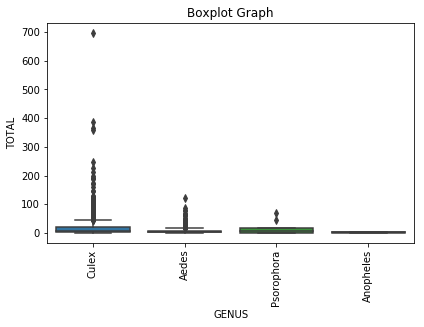

<Figure size 1080x1440 with 0 Axes>

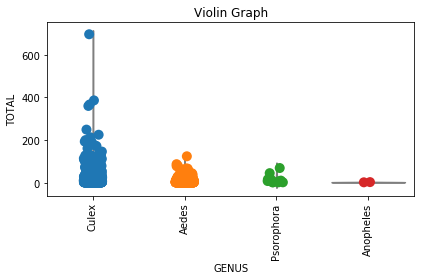

<Figure size 1080x1440 with 0 Axes>

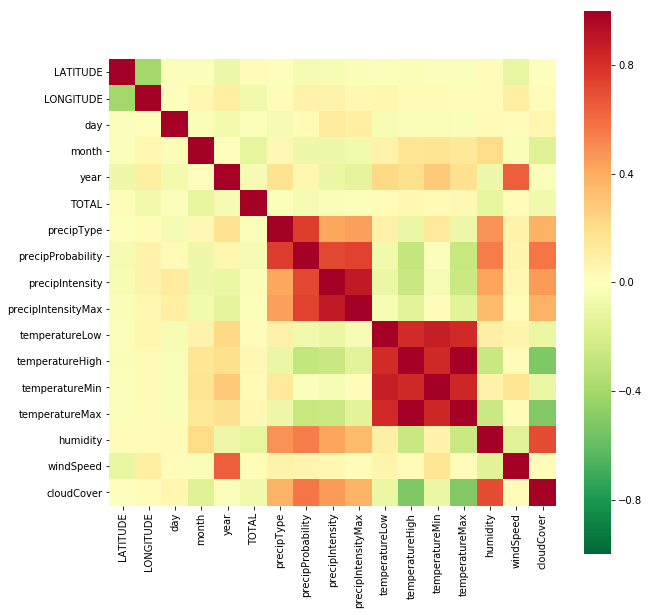

In [20]:
boxPlotFunc(result)
violinPlotFunc(result)
corrPlotFunc(result)

## SVM

In [0]:
# function to print SVM
def svmFunct(X,y):
  scoresCoef = []
  regrSVM = LinearSVR(random_state=0, tol=1e-5)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    regrSVM.fit(X_train, y_train)
    y_pred = regrSVM.predict(X_test)
      
  print(regrSVM.coef_)
  print(regrSVM.intercept_)

  
  fig, ax = plt.subplots()
  ax.scatter(y_test, y_pred)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  ax.set_xlabel('True Values')
  ax.set_ylabel('Predicted')
  plt.savefig('SVM.eps', format='eps', dpi=900)

  return plt.show()

[-0.25113741  2.16339263 -0.55205543 -0.91664807 -3.58813466 28.59602649
  4.87824683  0.34821731  0.48756825 -1.2411842  -0.66475177 -0.1157109
 -0.4752535   0.97456049  3.21207572 -0.5103231   0.86407773  1.86462407
 -0.87852372]
[2.85330141]


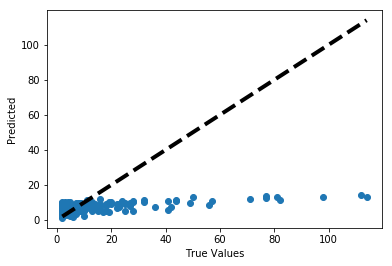

In [22]:
svmFunct(X,y)

## Linear Regression

In [0]:
def linearRegressionFunct(X,y):
  scoresCoef = []
  linreg = LinearRegression()
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
  
  print('Accuracy of linear regression classifier on test set: {:.2f}'.format(linreg.score(X_test,y_test)))
  #print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(linreg.score(testX, testY))
  print(linreg.coef_)
  print(linreg.intercept_)

  
  fig, ax = plt.subplots()
  ax.scatter(y_test, y_pred)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  ax.set_xlabel('True Values')
  ax.set_ylabel('Predicted')
  plt.savefig('linreg.eps', format='eps', dpi=900)

  return plt.show()

Accuracy of linear regression classifier on test set: 1.00
[-2.38839683e-15 -1.95399252e-14 -1.06122928e-13  8.71435419e-14
 -6.65456333e-14  6.94000000e+02  1.44712502e-14 -1.06770070e-13
 -1.80548695e-14  1.82743089e-14  1.49765455e-13  5.23878697e-14
  2.57483094e-14 -2.34272913e-14 -9.53508362e-14  1.59019265e-13
  1.48507318e-13  9.62563362e-14 -1.29771194e-13]
1.9999999999999574


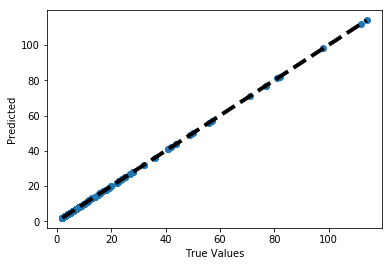

In [24]:
linearRegressionFunct(X,y)

## Hyperparameters

#### Dropout

In [25]:
dropout_10 = layers.Dropout(0.1,
               noise_shape=None,
               seed=1)

In [0]:
dropout_20 = layers.Dropout(0.2,
               noise_shape=None,
               seed=1)

In [0]:
dropout_50 = layers.Dropout(0.5,
               noise_shape=None,
               seed=1)

#### Lasso Regression

In [0]:
l1_reg10 = keras.regularizers.l1(0.001)

In [0]:
l1_reg20 = keras.regularizers.l1(0.2)

#### Ridge Regression

In [0]:
l2_reg10 = keras.regularizers.l2(0.1)

In [0]:
l2_reg20 = keras.regularizers.l2(0.2)

#### Lasso & Ridge

In [0]:
l1l2_reg = keras.regularizers.l1_l2(l1=0.01, l2=0.01)

### Batch Normalization

In [0]:
batch_normalization = layers.BatchNormalization(axis=-1, 
                                                momentum=0.999, 
                                                epsilon=0.0001, 
                                                center=True, 
                                                scale=True,
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones',
                                                beta_regularizer=None, 
                                                gamma_regularizer=None,
                                                beta_constraint=None,
                                                gamma_constraint=None)

### Custom Optimizers

In [0]:
adam_opt=optimizers.Adam(lr=0.001,
                   beta_1=0.9, 
                   beta_2=0.999,
                   epsilon=None,
                   decay=0.0,
                   amsgrad=False)

In [0]:
adadelta_opt = optimizers.Adadelta(lr=1.0,
                                   rho=0.95,
                                   epsilon=None,
                                   decay=0.0)

In [0]:
adadelta_opt = optimizers.Adadelta(lr=1.0,
                                   rho=0.95,
                                   epsilon=None,
                                   decay=0.0)

### Custom Activation Functions

In [0]:
leakyReLU_act = layers.LeakyReLU(alpha=0.3)

In [0]:
pReLU_act = layers.PReLU(alpha_initializer='zeros',
                         alpha_regularizer=None, 
                         alpha_constraint=None,
                         shared_axes=None)

In [0]:
elu_act = layers.ELU(alpha=1.0)

## Plot Functions

In [0]:
colorsList = ['b','g','r','m','y','c','k','w']
def lossTrainPlot(model_history):
  plt.title('Loss vs Epochs')
  for x in range(len(model_history)):
    plt.plot(model_history[x].history['loss'], label=('Training Fold ', x+1), color=colorsList[x])
  plt.legend()
  #plt.ylim(0,2)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/lossPlot.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
def lossValPlot(model_history):
  plt.title('Val Loss vs Epochs')
  for x in range(len(model_history)):
    plt.plot(model_history[x].history['val_loss'], label=('Val Fold ', x+1), color=colorsList[x])
  plt.legend()
  #plt.ylim(0,2)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/ValPlot.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
def lossTrainValPlot(model_history):
  plt.title('Train Loss vs Val Loss')
  for x in range(len(model_history)): 
    plt.plot(model_history[x].history['val_loss'], label=('Val Fold', x+1), color=colorsList[x])
    plt.plot(model_history[x].history['loss'], label=('Training Fold ', x+1), color=colorsList[x], linestyle = "dashdot")
  plt.legend(ncol=2)
  #plt.ylim(0,2)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/lossValPlot.eps', format='eps', dpi=900)
  return plt.show()

## Multi-Layer Perceptron

In [0]:
model_checkpoint = ModelCheckpoint('RegMos.h5', verbose=1, save_best_only=True)

#model of dense neural network with 16, 8, 4 and 1 neurons in each layer respectively 
def create_mlp(dim, regress=False):
  model = Sequential()
  model.add(Dense(16, input_shape=(dim,),activation="relu"))
  model.add(Dense(8, activation="relu"))
  model.add(Dense(4, activation="relu"))
  
  if regress:
    model.add(Dense(1, activation="linear"))
  
  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  model.compile(optimizer=opt, loss="mae", metrics=['mse'])
  
  return model



In [0]:
def kFoldMLP(X, y, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  mean_List = []
  std_List = []
  start = time.clock()                 
  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    model = create_mlp(X_train.shape[1], regress=True)

    history = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                        epochs=num_epochs,callbacks=[model_checkpoint,
                        TensorBoardColabCallback(tbc)], batch_size=batch_size, verbose=verbose)
    
    model_history.append(history)
    val_mape,val_mae = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(val_mape)

    mean, std = evaluateModel(X_test,y_test,model)
    print(mean)
    mean_List.append(mean)
    std_List.append(std)
    print(mean_List)
  
  plot_model(model, show_shapes = 1, to_file='DenseModel.png')
  model.summary()
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(avg(mean_List), avg(std_List)))
  return model, model_history, all_scores




Train on 1618 samples, validate on 405 samples







Epoch 1/50
1618/1618 [==============================] - 1s 437us/step - loss: 13.3559 - mean_squared_error: 1133.8045 - val_loss: 12.3783 - val_mean_squared_error: 909.1444

Epoch 00001: val_loss improved from inf to 12.37834, saving model to RegMos.h5

Epoch 2/50
1618/1618 [==============================] - 0s 263us/step - loss: 10.9633 - mean_squared_error: 1031.9777 - val_loss: 12.0540 - val_mean_squared_error: 862.3210

Epoch 00002: val_loss improved from 12.37834 to 12.05397, saving model to RegMos.h5
Epoch 3/50
1618/1618 [==============================] - 0s 262us/step - loss: 10.8069 - mean_squared_error: 1017.8377 - val_loss: 11.9784 - val_mean_squared_error: 856.3503

Epoch 00003: val_loss improved from 12.05397 to 11.97837, saving model to RegMos.h5
Epoch 4/50
1618/1618 [==============================] - 0s 261us/step - loss: 10.7087 - mean_squared_error: 1011.6841 - val_loss: 11.9096 - val_mean_squared_error: 851.7453


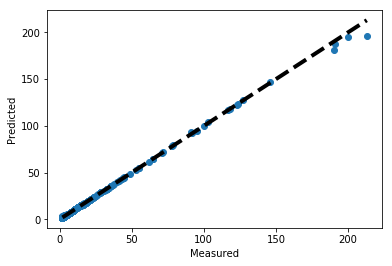

3.3602499896297258
[3.3602499896297258]
Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 1s 340us/step - loss: 12.4867 - mean_squared_error: 753.4534 - val_loss: 12.2559 - val_mean_squared_error: 2276.9691

Epoch 00001: val_loss did not improve from 0.21433
Epoch 2/50
1618/1618 [==============================] - 0s 259us/step - loss: 10.8692 - mean_squared_error: 674.2658 - val_loss: 12.1130 - val_mean_squared_error: 2254.4174

Epoch 00002: val_loss did not improve from 0.21433
Epoch 3/50
1618/1618 [==============================] - 0s 259us/step - loss: 10.7611 - mean_squared_error: 663.5971 - val_loss: 12.0220 - val_mean_squared_error: 2250.8195

Epoch 00003: val_loss did not improve from 0.21433
Epoch 4/50
1618/1618 [==============================] - 0s 271us/step - loss: 10.6786 - mean_squared_error: 664.0779 - val_loss: 11.9394 - val_mean_squared_error: 2233.6055

Epoch 00004: val_loss did not improve from 0.21433
Epoch 5/50
16

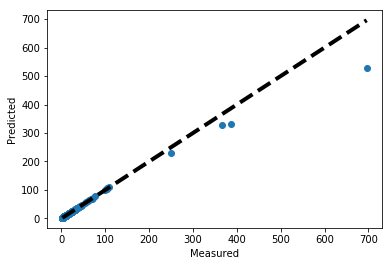

3.2724261595358484
[3.3602499896297258, 3.2724261595358484]
Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 1s 368us/step - loss: 13.1585 - mean_squared_error: 1188.8867 - val_loss: 10.6267 - val_mean_squared_error: 626.4425

Epoch 00001: val_loss did not improve from 0.21433
Epoch 2/50
1618/1618 [==============================] - 0s 260us/step - loss: 11.3507 - mean_squared_error: 1096.1560 - val_loss: 10.4089 - val_mean_squared_error: 596.6334

Epoch 00002: val_loss did not improve from 0.21433
Epoch 3/50
1618/1618 [==============================] - 0s 264us/step - loss: 11.2729 - mean_squared_error: 1083.7559 - val_loss: 10.3477 - val_mean_squared_error: 593.2683

Epoch 00003: val_loss did not improve from 0.21433
Epoch 4/50
1618/1618 [==============================] - 0s 287us/step - loss: 11.2110 - mean_squared_error: 1079.2558 - val_loss: 10.2853 - val_mean_squared_error: 588.3046

Epoch 00004: val_loss did not improve from 0

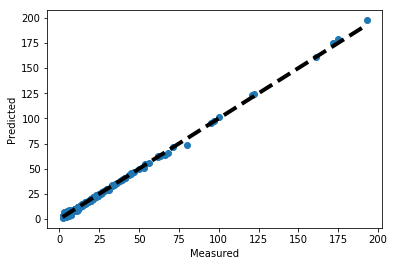

7.502407853977096
[3.3602499896297258, 3.2724261595358484, 7.502407853977096]
Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 1s 379us/step - loss: 12.5603 - mean_squared_error: 1131.7230 - val_loss: 10.8779 - val_mean_squared_error: 759.6972

Epoch 00001: val_loss did not improve from 0.21433
Epoch 2/50
1619/1619 [==============================] - 0s 265us/step - loss: 11.2040 - mean_squared_error: 1051.3665 - val_loss: 10.7133 - val_mean_squared_error: 743.9879

Epoch 00002: val_loss did not improve from 0.21433
Epoch 3/50
1619/1619 [==============================] - 0s 251us/step - loss: 11.0641 - mean_squared_error: 1042.0469 - val_loss: 10.5265 - val_mean_squared_error: 735.3506

Epoch 00003: val_loss did not improve from 0.21433
Epoch 4/50
1619/1619 [==============================] - 0s 266us/step - loss: 10.9409 - mean_squared_error: 1031.4312 - val_loss: 10.4305 - val_mean_squared_error: 722.9032

Epoch 00004: val_loss did 

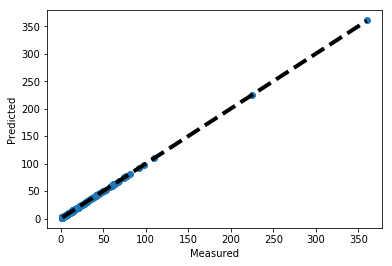

3.0016406247315466
[3.3602499896297258, 3.2724261595358484, 7.502407853977096, 3.0016406247315466]
Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 1s 392us/step - loss: 14.7921 - mean_squared_error: 1262.8943 - val_loss: 13.4978 - val_mean_squared_error: 612.0708

Epoch 00001: val_loss did not improve from 0.13448
Epoch 2/50
1619/1619 [==============================] - 0s 259us/step - loss: 14.6524 - mean_squared_error: 1258.7770 - val_loss: 13.3952 - val_mean_squared_error: 609.3235

Epoch 00002: val_loss did not improve from 0.13448
Epoch 3/50
1619/1619 [==============================] - 0s 261us/step - loss: 14.5503 - mean_squared_error: 1255.7163 - val_loss: 13.2933 - val_mean_squared_error: 606.6043

Epoch 00003: val_loss did not improve from 0.13448
Epoch 4/50
1619/1619 [==============================] - 0s 261us/step - loss: 14.4484 - mean_squared_error: 1252.7755 - val_loss: 13.1914 - val_mean_squared_error: 603.9076

Epoch

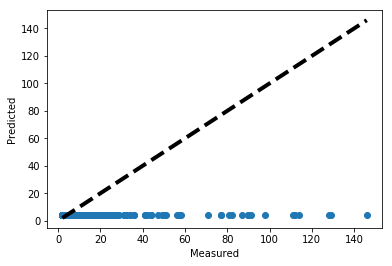

58.42347904936017
[3.3602499896297258, 3.2724261595358484, 7.502407853977096, 3.0016406247315466, 58.42347904936017]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 16)                320       
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
Total Time: 178.408099 
[INFO] avg. mosquito traped: 14.563519525457242, std mosquito trapped: 30.36583394682834
[INFO] mean: 15.11%, std

In [36]:
#model, model_history, all_scores = kFoldMLP(X,y,folds=3, num_epochs=3,verbose=False)
model, model_history, all_scores = kFoldMLP(X,y)

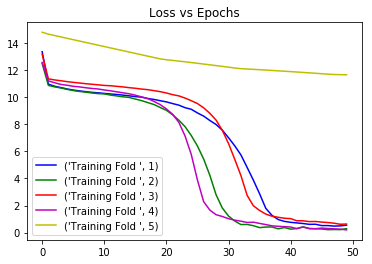

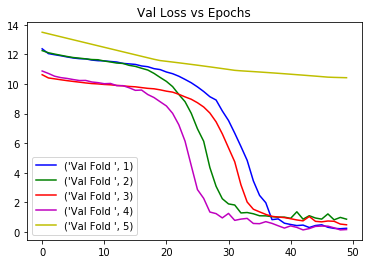

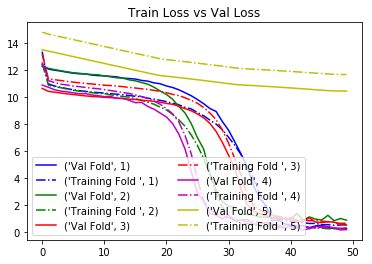

In [37]:
lossTrainPlot(model_history)
lossValPlot(model_history)
lossTrainValPlot(model_history)

In [0]:
def WeightsLayers(model):
  for layer in model.layers:
      weights = layer.get_weights()
  print(weights)
  return

In [39]:
WeightsLayers(model)

[array([[-0.9525514 ],
       [-0.49521038],
       [-0.8880655 ],
       [-0.32282832]], dtype=float32), array([4.1249003], dtype=float32)]


In [0]:
def loadBestModel(modelName):

  model = load_model(modelName)
  model.load_weights(modelName)
  print("Loaded model from disk")

  # evaluate loaded model on test data 
  # Define X_test & Y_test data first
  model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mape'])
  score = model.evaluate(testX, testY, verbose=0)
  print ("%s: %.2f%%" % (model.metrics_names[1], score[1]))
  preds = model.predict(testX)

  fig, ax = plt.subplots()
  ax.scatter(testY, preds)
  ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()
  return

In [0]:
'''modelName = 'RegMos.h5'
loadBestModel(modelName)'''

"modelName = 'RegMos.h5'\nloadBestModel(modelName)"

## Transfer Learning

### VGG19

In [0]:
def vgg19Model(width, height, depth):
  
  inputShape = (height, width, depth)
  base_modelVgg19=VGG19(weights='imagenet',
                        include_top=False,
                        input_shape=inputShape)

  model = Sequential()
  model.add(base_modelVgg19)
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(128, activation='linear'))
  model.add(layers.LeakyReLU(alpha=0.1))           
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam',loss='mae',metrics=['mse'])
  return model

In [0]:
start = time.clock() 
historyConvTransf = modelTransf.fit(x_train,train_small_with_dummies, 
                                    validation_data=(x_valid, train_small_with_dummies2),
                                    batch_size=128,verbose=2, nb_epoch=256,shuffle=True)

end = time.clock()
timeConvTL = end-start

print("Total Time: {} ".format(timeConvTL)) 

In [0]:
historyConvTransfDA = modelTransf.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

### ResNet 50

In [0]:
def resnet50Model(width, height, depth):
  
  inputShape = (height, width, depth)
  base_modelRes=ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=inputShape)

  model = Sequential()
  model.add(base_modelRes)
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(128, activation='linear'))
  model.add(layers.LeakyReLU(alpha=0.1))           
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam',loss='mae',metrics=['mse'])
  return model

In [0]:
start = time.clock() 
historyRes = modelTransf2.fit(x_train,train_small_with_dummies, 
                                    validation_data=(x_valid, train_small_with_dummies2),
                                    batch_size=128,verbose=2, nb_epoch=256,shuffle=True)

end = time.clock()
timeRes = end-start

print("Total Time: {} ".format(timeRes)) 

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 1680 samples, validate on 420 samples
Epoch 1/256
 - 23s - loss: 1.6648 - acc: 0.5738 - val_loss: 7.2263 - val_acc: 0.3857
Epoch 2/256
 - 3s - loss: 0.9536 - acc: 0.7357 - val_loss: 12.0762 - val_acc: 0.1619
Epoch 3/256
 - 3s - loss: 0.6928 - acc: 0.8137 - val_loss: 11.9348 - val_acc: 0.1452
Epoch 4/256
 - 3s - loss: 0.4888 - acc: 0.8423 - val_loss: 8.9149 - val_acc: 0.1762
Epoch 5/256
 - 3s - loss: 0.5482 - acc: 0.8506 - val_loss: 5.6143 - val_acc: 0.3048
Epoch 6/256
 - 3s - loss: 0.5075 - acc: 0.8708 - val_loss: 10.5026 - val_acc: 0.1714
Epoch 7/256
 - 3s - loss: 0.2891 - acc: 0.9095 - val_loss: 3.9916 - val_acc: 0.4929
Epoch 8/256
 - 3s - loss: 0.2819 - acc: 0.9107 - val_loss: 5.2025 - val_acc: 0.5286
Epoch 9/256
 - 3s - loss: 0.3272 - acc: 0.9024 - val_loss: 5.6613 - val_acc: 0.3857
Epoch 10/256
 - 3s - loss: 0.2176 - acc: 0.9274 - val_loss: 4.9551 - val_acc: 0.4167
Epoch 11/256
 - 3s - loss: 0.1586 - acc: 0.9339 - val_loss: 5.8298 - val_acc: 0.4095
Epoch 12/256
 - 3s - lo

In [0]:
#ResNet with Data Augmentantion
historyResDA = modelTransf2.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

Epoch 1/256
 - 23s - loss: 3.3398 - acc: 0.2031 - val_loss: 5.3168 - val_acc: 0.2534
Epoch 2/256
 - 5s - loss: 2.7254 - acc: 0.3542 - val_loss: 7.9000 - val_acc: 0.2084
Epoch 3/256
 - 5s - loss: 2.5293 - acc: 0.3490 - val_loss: 7.7688 - val_acc: 0.2612
Epoch 4/256
 - 5s - loss: 2.3101 - acc: 0.3646 - val_loss: 5.9448 - val_acc: 0.3007
Epoch 5/256
 - 5s - loss: 2.2501 - acc: 0.4010 - val_loss: 4.3910 - val_acc: 0.2937
Epoch 6/256
 - 6s - loss: 2.4885 - acc: 0.4271 - val_loss: 6.8921 - val_acc: 0.1907
Epoch 7/256
 - 5s - loss: 2.5360 - acc: 0.4010 - val_loss: 9.0034 - val_acc: 0.1200
Epoch 8/256
 - 5s - loss: 2.7296 - acc: 0.3906 - val_loss: 7.0437 - val_acc: 0.1376
Epoch 9/256
 - 5s - loss: 2.5865 - acc: 0.3360 - val_loss: 12.2159 - val_acc: 0.0786
Epoch 10/256
 - 5s - loss: 2.5090 - acc: 0.3958 - val_loss: 14.1588 - val_acc: 0.0315
Epoch 11/256
 - 5s - loss: 3.2651 - acc: 0.2552 - val_loss: 15.4258 - val_acc: 0.0315
Epoch 12/256
 - 6s - loss: 2.8837 - acc: 0.2760 - val_loss: 15.3174 - 

### Transfer Learning ResNet

In [0]:
'''modelTransf2=ResNet50(weights=None,
                      include_top=True,
                      classes=1,
                      input_shape=(64,64,3))

modelTransf2 = Sequential()


modelTransf2.add(base_modelRes)
modelTransf2.add(Flatten())
modelTransf2.add(BatchNormalization())
modelTransf2.add(Dense(128, activation='linear'))
modelTransf2.add(layers.LeakyReLU(alpha=0.1))           
modelTransf2.add(Dropout(0.3))
modelTransf2.add(Dense(21, activation='softmax'))

modelTransf2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])'''

In [0]:
'''#ResNet50 Vainilla
start = time.clock() 
historyRes = modelTransf2.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),epochs=200, batch_size=8)

end = time.clock()
timeRes = end-start

print("Total Time: {} ".format(timeRes)) '''

In [0]:
'''train_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True)

train_generator.fit(trainImagesX)
#ResNet with Data Augmentantion
historyResDA = modelTransf2.fit_generator(
        train_generator.flow(trainImagesX, trainY,epochs=200, batch_size=8),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(testImagesX, testY), batch_size=32),
        validation_steps=128,
        verbose=2
    )'''

## Retrieve Images

In [0]:
def retrieveImages(result,inputPath,imgSize):
  start = time.clock() 

  images = []

  for i in result['LATITUDE']:
    basePath = os.path.sep.join([inputPath, "{},*".format(i)])
    imagePaths = sorted(list(glob.glob(basePath)))
    
    for imagePath in imagePaths:
      image = cv2.imread(imagePath)
      image = cv2.resize(image, (imgSize, imgSize))
      image = image.flatten()
      images.append(image)

  end = time.clock()
  timeImages = end-start

  print("Total Time: {} ".format(timeImages)) 
  images = np.array(images)
  images = images / 255.0
  print('X shape:', np.array(X).shape)
  print('y shape:', np.array(y).shape)
  print('images shape:', np.array(images).shape)
  return images

In [44]:
inputPath = '/content/drive/My Drive/mosquito/imagesWashington'
#inputPath = '/content/drive/My Drive/mosquito/imagesManatee'
#inputPath = '/content/drive/My Drive/mosquito/imagesHernando'
images = retrieveImages(result,inputPath,64)

Total Time: 6.529796000000005 
X shape: (2023, 19)
y shape: (2023,)
images shape: (2023, 12288)


In [0]:
images

In [0]:
'''pd.DataFrame(images).to_csv("imagesManatee_128_80.csv", header=None, index=None)
start = time.clock() 
images = pd.read_csv("images_64.csv", header=None)
images = images.values
end = time.clock()
timeImages = end-start
print("Total Time: {} ".format(timeImages)) '''

## CNN with Images

In [0]:
model_checkpoint2 = ModelCheckpoint('RegMosRes.h5', verbose=1, save_best_only=True)
def create_cnn(width, height, depth, filters=(16,32,64),regress=False):
  
  inputShape = (height, width, depth)
  chanDim = -1
  
  inputs = Input(shape=inputShape)
  
  for (i,f) in enumerate(filters):
    if i == 0:
      x = inputs
      
    x = Conv2D(f, (3,3), padding='same', kernel_regularizer='l2')(x)
    x = Activation ('relu')(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
  x = Flatten()(x)
  x = Dense(16)(x)
  x = Activation('relu')(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Dropout(0.5)(x)
  
  x = Dense(4)(x)
  x = Activation('relu')(x)
  
  if regress:
    x = Dense(1,activation='linear')(x)
    
  model = Model(inputs,x)
  opt = Adam(lr=1e-3, decay=1e-3 / 200) 
  model.compile(optimizer=opt, loss="mae", metrics=['mse'])
  
  return model

In [0]:
def evaluateCNN(images,X,y,imgSize, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  mean_List = []
  std_List = []
  start = time.clock()                 

  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  aug = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   shear_range=0.2, rotation_range=30) 
  
  for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = images[train_index], images[test_index], y[train_index], y[test_index]
    
    X_train = X_train.reshape((X_train.shape[0], imgSize, imgSize, 3))
    X_test = X_test.reshape((X_test.shape[0], imgSize, imgSize, 3))

    #model = create_cnn(imgSize, imgSize, 3, regress=True)
    model = vgg19Model(imgSize, imgSize, 3)
    #model = resnet50Model(imgSize, imgSize, 3)

    history = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                        epochs=num_epochs,callbacks=[model_checkpoint2,
                        TensorBoardColabCallback(tbc)], batch_size=batch_size, verbose=verbose)
    
    model_history.append(history)
    val_mape,val_mae = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(val_mape)

    mean,std = evaluateModel(X_test,y_test,model)

    mean_List.append(mean)
    std_List.append(std)
  

  '''with open('file.json', 'w') as f:
    json.dump(hist.history, f)'''
  plot_model(model, show_shapes = 1, to_file='CNNModel.png')
  model.summary()
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(avg(mean_List), avg(std_List)))
  return model, model_history, all_scores




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 5s 3ms/step - loss: 13.0924 - mean_squared_error: 1102.2006 - val_loss: 12.9612 - val_mean_squared_error: 896.8553

Epoch 00001: val_loss improved from inf to 12.96122, saving model to RegMos2.h5
Epoch 2/50
1618/1618 [==============================] - 2s 928us/step - loss: 11.9880 - mean_squared_error: 1062.6173 - val_loss: 12.6877 - val_mean_squared_error: 866.1078

Epoch 00002: val_loss improved from 12.96122 to 12.68767, saving model to RegMos2.h5
Epoch 3/50
1618/1618 [==============================] - 2s 953us/step - loss: 11.6229 - mean_squared_error: 1043.7651 - val_loss: 12.5512 - val_mean_squared_error: 859.8838

Epoch 00003: val_loss improved from 12.68767 to 12.55117, saving model to RegMos2.h5
Epoch 4/50
1618/1618 [==============================] - 2s 956us/

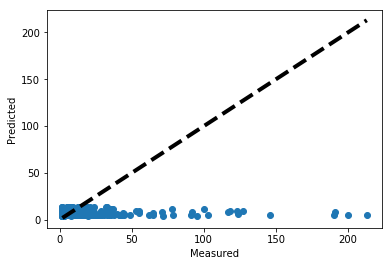

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 3s 2ms/step - loss: 13.2391 - mean_squared_error: 762.3679 - val_loss: 13.6392 - val_mean_squared_error: 2333.3129

Epoch 00001: val_loss did not improve from 12.04375
Epoch 2/50
1618/1618 [==============================] - 2s 996us/step - loss: 12.0704 - mean_squared_error: 720.3696 - val_loss: 12.8880 - val_mean_squared_error: 2258.8521

Epoch 00002: val_loss did not improve from 12.04375
Epoch 3/50
1618/1618 [==============================] - 2s 981us/step - loss: 11.6802 - mean_squared_error: 699.9819 - val_loss: 14.5732 - val_mean_squared_error: 2254.1525

Epoch 00003: val_loss did not improve from 12.04375
Epoch 4/50
1618/1618 [==============================] - 2s 997us/step - loss: 11.4984 - mean_squared_error: 689.6740 - val_loss: 12.7293 - val_mean_squared_error: 2291.8839

Epoch 00004: val_loss did not improve from 12.04375
Epoch 5/50
1618/1618 [=============================

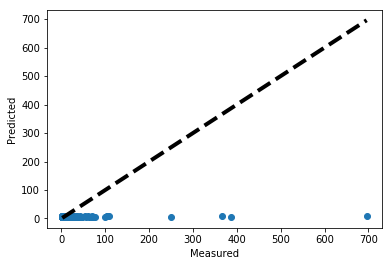

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 3s 2ms/step - loss: 15.4036 - mean_squared_error: 1238.9517 - val_loss: 13.4802 - val_mean_squared_error: 705.0199

Epoch 00001: val_loss did not improve from 12.04375
Epoch 2/50
1618/1618 [==============================] - 2s 997us/step - loss: 14.1508 - mean_squared_error: 1201.3741 - val_loss: 12.2645 - val_mean_squared_error: 669.1560

Epoch 00002: val_loss did not improve from 12.04375
Epoch 3/50
1618/1618 [==============================] - 2s 1ms/step - loss: 13.3834 - mean_squared_error: 1171.1523 - val_loss: 11.8163 - val_mean_squared_error: 652.0584

Epoch 00003: val_loss improved from 12.04375 to 11.81629, saving model to RegMos2.h5
Epoch 4/50
1618/1618 [==============================] - 2s 1000us/step - loss: 12.8113 - mean_squared_error: 1139.0396 - val_loss: 12.2127 - val_mean_squared_error: 573.6273

Epoch 00004: val_loss did not improve from 11.81629
Epoch 5/50
1618/161

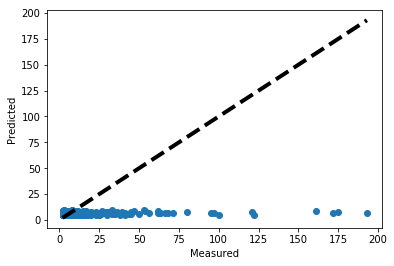

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 3s 2ms/step - loss: 14.7702 - mean_squared_error: 1183.8365 - val_loss: 12.9642 - val_mean_squared_error: 837.7324

Epoch 00001: val_loss did not improve from 10.33380
Epoch 2/50
1619/1619 [==============================] - 2s 993us/step - loss: 13.5811 - mean_squared_error: 1150.7375 - val_loss: 12.6033 - val_mean_squared_error: 826.3397

Epoch 00002: val_loss did not improve from 10.33380
Epoch 3/50
1619/1619 [==============================] - 2s 1ms/step - loss: 12.8844 - mean_squared_error: 1123.5106 - val_loss: 12.4812 - val_mean_squared_error: 826.1489

Epoch 00003: val_loss did not improve from 10.33380
Epoch 4/50
1619/1619 [==============================] - 2s 1ms/step - loss: 12.2743 - mean_squared_error: 1091.0251 - val_loss: 13.1785 - val_mean_squared_error: 843.6975

Epoch 00004: val_loss did not improve from 10.33380
Epoch 5/50
1619/1619 [==============================] -

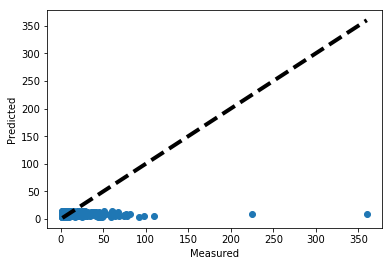

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 3s 2ms/step - loss: 15.0091 - mean_squared_error: 1253.1486 - val_loss: 13.1460 - val_mean_squared_error: 588.4894

Epoch 00001: val_loss did not improve from 10.33380
Epoch 2/50
1619/1619 [==============================] - 2s 1ms/step - loss: 13.6882 - mean_squared_error: 1217.7471 - val_loss: 12.0679 - val_mean_squared_error: 561.9929

Epoch 00002: val_loss did not improve from 10.33380
Epoch 3/50
1619/1619 [==============================] - 2s 1ms/step - loss: 12.5998 - mean_squared_error: 1183.1437 - val_loss: 11.1541 - val_mean_squared_error: 528.1392

Epoch 00003: val_loss did not improve from 10.33380
Epoch 4/50
1619/1619 [==============================] - 2s 1ms/step - loss: 12.0922 - mean_squared_error: 1152.9779 - val_loss: 11.7364 - val_mean_squared_error: 477.2271

Epoch 00004: val_loss did not improve from 10.33380
Epoch 5/50
1619/1619 [==============================] - 2

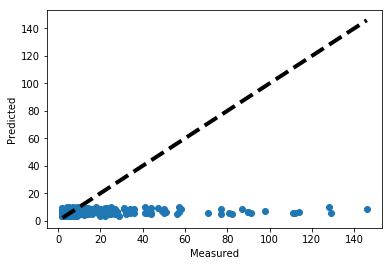

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
activation_21 (Activation)   (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0   

In [47]:
#model2, model_history2, all_scores2 = evaluateCNN(images,X,y, 64, folds=3, num_epochs=3, batch_size=16, verbose=True)
model2, model_history2, all_scores2 = evaluateCNN(images,X,y,64)

80142336/80134624 [==============================] - 3s 0us/step
Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 16s 10ms/step - loss: 11.7704 - mean_squared_error: 1043.5141 - val_loss: 108085.5006 - val_mean_squared_error: 97740533245.5944

Epoch 00001: val_loss improved from inf to 108085.50061, saving model to RegMosVGG.h5
Epoch 2/50
1618/1618 [==============================] - 13s 8ms/step - loss: 11.4261 - mean_squared_error: 1024.3714 - val_loss: 164.5921 - val_mean_squared_error: 28210.9221

Epoch 00002: val_loss improved from 108085.50061 to 164.59209, saving model to RegMosVGG.h5
Epoch 3/50
1618/1618 [==============================] - 13s 8ms/step - loss: 11.2027 - mean_squared_error: 1002.6935 - val_loss: 13.4792 - val_mean_squared_error: 787.4339

Epoch 00003: val_loss improved from 164.59209 to 13.47918, saving model to RegMosVGG.h5
Epoch 4/50
1618/1618 [==============================] - 13s 8ms/step - loss: 11.1337 - 

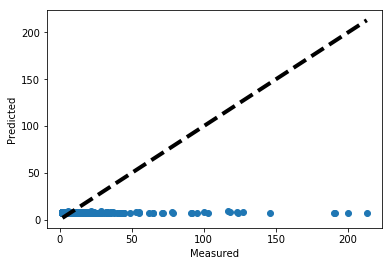

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 14s 9ms/step - loss: 11.3810 - mean_squared_error: 681.1697 - val_loss: 13.2978 - val_mean_squared_error: 2211.6754

Epoch 00001: val_loss did not improve from 12.07007
Epoch 2/50
1618/1618 [==============================] - 13s 8ms/step - loss: 11.0668 - mean_squared_error: 669.1110 - val_loss: 26.8197 - val_mean_squared_error: 2466.0385

Epoch 00002: val_loss did not improve from 12.07007
Epoch 3/50
1618/1618 [==============================] - 13s 8ms/step - loss: 10.9981 - mean_squared_error: 667.5614 - val_loss: 30.1202 - val_mean_squared_error: 2594.5346

Epoch 00003: val_loss did not improve from 12.07007
Epoch 4/50
1618/1618 [==============================] - 13s 8ms/step - loss: 10.9131 - mean_squared_error: 671.3386 - val_loss: 12.1806 - val_mean_squared_error: 2249.7598

Epoch 00004: val_loss did not improve from 12.07007
Epoch 5/50
1618/1618 [==============================]

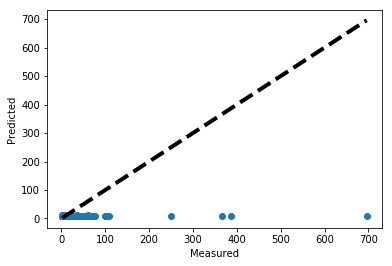

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 14s 9ms/step - loss: 12.2888 - mean_squared_error: 1101.6463 - val_loss: 68960605.0963 - val_mean_squared_error: 4837061810191737.0000

Epoch 00001: val_loss did not improve from 12.07007
Epoch 2/50
1618/1618 [==============================] - 13s 8ms/step - loss: 11.8010 - mean_squared_error: 1056.7831 - val_loss: 10.5987 - val_mean_squared_error: 561.3910

Epoch 00002: val_loss improved from 12.07007 to 10.59870, saving model to RegMosVGG.h5
Epoch 3/50
1618/1618 [==============================] - 13s 8ms/step - loss: 11.6190 - mean_squared_error: 1091.1547 - val_loss: 57.0602 - val_mean_squared_error: 3962.9894

Epoch 00003: val_loss did not improve from 10.59870
Epoch 4/50
1618/1618 [==============================] - 13s 8ms/step - loss: 11.5424 - mean_squared_error: 1082.3885 - val_loss: 11.5099 - val_mean_squared_error: 607.7250

Epoch 00004: val_loss did not improve from 10.5987

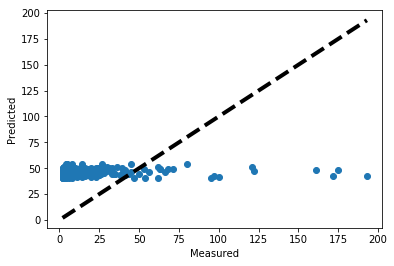

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 16s 10ms/step - loss: 11.7355 - mean_squared_error: 1057.4093 - val_loss: 1501.3491 - val_mean_squared_error: 2799537.9208

Epoch 00001: val_loss did not improve from 10.32233
Epoch 2/50
1619/1619 [==============================] - 13s 8ms/step - loss: 11.4373 - mean_squared_error: 1036.9952 - val_loss: 108.1807 - val_mean_squared_error: 12100.4655

Epoch 00002: val_loss did not improve from 10.32233
Epoch 3/50
1619/1619 [==============================] - 13s 8ms/step - loss: 11.5129 - mean_squared_error: 1040.9057 - val_loss: 10.8825 - val_mean_squared_error: 757.8142

Epoch 00003: val_loss did not improve from 10.32233
Epoch 4/50
1619/1619 [==============================] - 13s 8ms/step - loss: 11.5498 - mean_squared_error: 1052.8597 - val_loss: 33.6725 - val_mean_squared_error: 2346.5887

Epoch 00004: val_loss did not improve from 10.32233
Epoch 5/50
1619/1619 [====================

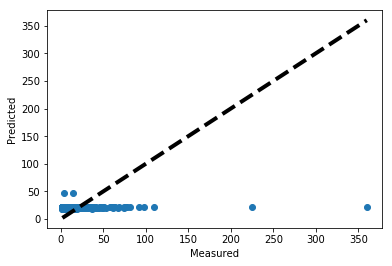

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 15s 9ms/step - loss: 12.0410 - mean_squared_error: 1128.9786 - val_loss: 10.9366 - val_mean_squared_error: 460.5224

Epoch 00001: val_loss did not improve from 10.32233
Epoch 2/50
1619/1619 [==============================] - 13s 8ms/step - loss: 11.5615 - mean_squared_error: 1116.0775 - val_loss: 28.5486 - val_mean_squared_error: 1050.3655

Epoch 00002: val_loss did not improve from 10.32233
Epoch 3/50
1619/1619 [==============================] - 13s 8ms/step - loss: 11.6238 - mean_squared_error: 1111.5045 - val_loss: 11.3252 - val_mean_squared_error: 436.9932

Epoch 00003: val_loss did not improve from 10.32233
Epoch 4/50
1619/1619 [==============================] - 13s 8ms/step - loss: 11.4688 - mean_squared_error: 1111.1876 - val_loss: 9071638487.4455 - val_mean_squared_error: 82966864105572450304.0000

Epoch 00004: val_loss did not improve from 10.32233
Epoch 5/50
1619/1619 [=====

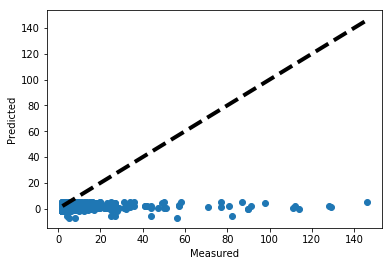

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_52 (Dense)             (None, 128)               262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)               

In [53]:
modelVGG, model_historyVGG, all_scoresVGG = evaluateCNN(images,X,y,64)


94658560/94653016 [==============================] - 4s 0us/step
Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 34s 21ms/step - loss: 12.4636 - mean_squared_error: 1049.9695 - val_loss: 26.0547 - val_mean_squared_error: 1901.8760

Epoch 00001: val_loss improved from inf to 26.05470, saving model to RegMosRes.h5
Epoch 2/50
1618/1618 [==============================] - 21s 13ms/step - loss: 11.9297 - mean_squared_error: 1036.1579 - val_loss: 102.2621 - val_mean_squared_error: 14605.8833

Epoch 00002: val_loss did not improve from 26.05470
Epoch 3/50
1618/1618 [==============================] - 20s 13ms/step - loss: 11.6581 - mean_squared_error: 1032.2424 - val_loss: 2102.1530 - val_mean_squared_error: 5230742.9617

Epoch 00003: val_loss did not improve from 26.05470
Epoch 4/50
1618/1618 [==============================] - 20s 13ms/step - loss: 11.4774 - mean_squared_error: 1028.9541 - val_loss: 12.3919 - val_mean_squared_error: 824.9

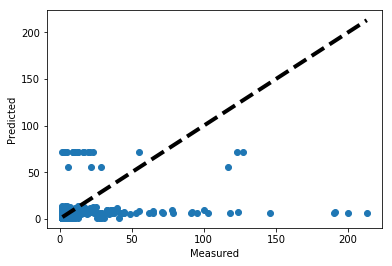

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 33s 20ms/step - loss: 12.3359 - mean_squared_error: 700.9817 - val_loss: 23754.2346 - val_mean_squared_error: 579962337.5012

Epoch 00001: val_loss did not improve from 11.98395
Epoch 2/50
1618/1618 [==============================] - 20s 13ms/step - loss: 11.8919 - mean_squared_error: 686.9646 - val_loss: 20922.7191 - val_mean_squared_error: 629509080.8099

Epoch 00002: val_loss did not improve from 11.98395
Epoch 3/50
1618/1618 [==============================] - 20s 13ms/step - loss: 11.8962 - mean_squared_error: 698.3263 - val_loss: 107746.2992 - val_mean_squared_error: 17611794065.3827

Epoch 00003: val_loss did not improve from 11.98395
Epoch 4/50
1618/1618 [==============================] - 20s 13ms/step - loss: 11.4187 - mean_squared_error: 677.1748 - val_loss: 107.0094 - val_mean_squared_error: 39314.1581

Epoch 00004: val_loss did not improve from 11.98395
Epoch 5/50
1618/1618

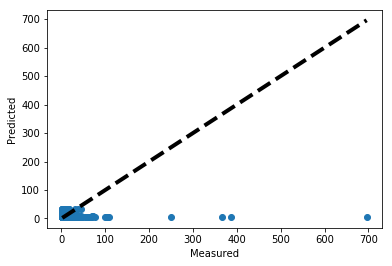

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 35s 21ms/step - loss: 12.8179 - mean_squared_error: 1125.4136 - val_loss: 268.0275 - val_mean_squared_error: 489175.5213

Epoch 00001: val_loss did not improve from 11.98395
Epoch 2/50
1618/1618 [==============================] - 21s 13ms/step - loss: 12.2213 - mean_squared_error: 1086.5810 - val_loss: 11.8976 - val_mean_squared_error: 680.0760

Epoch 00002: val_loss improved from 11.98395 to 11.89763, saving model to RegMosRes.h5
Epoch 3/50
1618/1618 [==============================] - 21s 13ms/step - loss: 12.1948 - mean_squared_error: 1110.5685 - val_loss: 1425.3267 - val_mean_squared_error: 4281887.0444

Epoch 00003: val_loss did not improve from 11.89763
Epoch 4/50
1618/1618 [==============================] - 21s 13ms/step - loss: 12.1007 - mean_squared_error: 1090.5328 - val_loss: 45.2819 - val_mean_squared_error: 12667.6704

Epoch 00004: val_loss did not improve from 11.89763
Ep

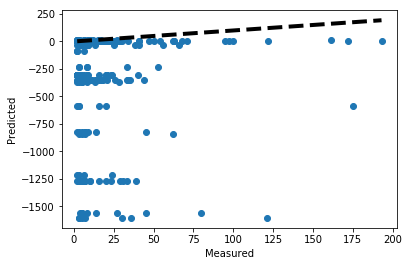

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 39s 24ms/step - loss: 12.9212 - mean_squared_error: 1081.9944 - val_loss: 20.7308 - val_mean_squared_error: 1907.8985

Epoch 00001: val_loss did not improve from 10.23831
Epoch 2/50
1619/1619 [==============================] - 21s 13ms/step - loss: 12.4696 - mean_squared_error: 1082.6433 - val_loss: 23.9253 - val_mean_squared_error: 1838.9935

Epoch 00002: val_loss did not improve from 10.23831
Epoch 3/50
1619/1619 [==============================] - 21s 13ms/step - loss: 12.0379 - mean_squared_error: 1052.3608 - val_loss: 29.3014 - val_mean_squared_error: 4141.8694

Epoch 00003: val_loss did not improve from 10.23831
Epoch 4/50
1619/1619 [==============================] - 21s 13ms/step - loss: 11.7155 - mean_squared_error: 1058.3373 - val_loss: 18.5939 - val_mean_squared_error: 1378.8238

Epoch 00004: val_loss did not improve from 10.23831
Epoch 5/50
1619/1619 [=======================

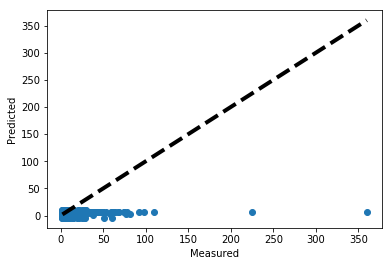

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 38s 23ms/step - loss: 12.7972 - mean_squared_error: 1120.3154 - val_loss: 89.9528 - val_mean_squared_error: 25664.1348

Epoch 00001: val_loss did not improve from 10.23831
Epoch 2/50
1619/1619 [==============================] - 21s 13ms/step - loss: 12.5269 - mean_squared_error: 1133.3449 - val_loss: 28.9503 - val_mean_squared_error: 1293.6384

Epoch 00002: val_loss did not improve from 10.23831
Epoch 3/50
1619/1619 [==============================] - 21s 13ms/step - loss: 12.1853 - mean_squared_error: 1145.3867 - val_loss: 450.0402 - val_mean_squared_error: 1339513.6379

Epoch 00003: val_loss did not improve from 10.23831
Epoch 4/50
1619/1619 [==============================] - 21s 13ms/step - loss: 12.0715 - mean_squared_error: 1134.8768 - val_loss: 517.9139 - val_mean_squared_error: 1135879.3252

Epoch 00004: val_loss did not improve from 10.23831
Epoch 5/50
1619/1619 [==============

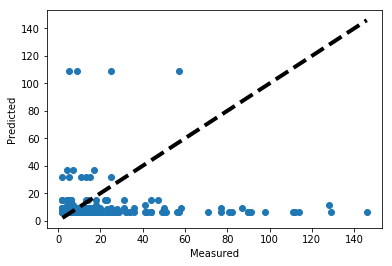

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 8192)              32768     
_________________________________________________________________
dense_62 (Dense)             (None, 128)               1048704   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)               

In [58]:
modelRes, model_historyRes, all_scoresRes = evaluateCNN(images,X,y,64)

In [0]:
lossTrainPlot(model_history2)
lossValPlot(model_history2)
lossTrainValPlot(model_history2)

In [0]:
WeightsLayers(model2)

[array([[ 0.5833018 ],
       [ 0.10444662],
       [-0.18700325],
       [ 0.45983508]], dtype=float32), array([1.3516402], dtype=float32)]


## Combine the models

In [0]:
model_checkpoint3 = ModelCheckpoint('RegMos3.h5', verbose=1, save_best_only=True)
def hybridModel(X_train,imgSize):
  mlp = create_mlp(X_train.shape[1], regress=False)
  cnn = create_cnn(imgSize, imgSize, 3, filters=(16,32,64),regress=False)

  combinedInput = concatenate([mlp.output, cnn.output])

  x = Dense(8, activation="relu")(combinedInput)
  x = Dense(4, activation="relu")(x)
  x = Dense(1, activation="linear")(x)

  modelF = Model(inputs=[mlp.input, cnn.input], outputs=x)

  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  modelF.compile(optimizer=opt, loss="mae", metrics=['mse'])
  
  return modelF

In [0]:
def evaluateHybrid(images,X,y,imgSize=64, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  mean_List = []
  std_List = []
  start = time.clock()                 

  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  aug = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   shear_range=0.2, rotation_range=30) 

  
  for train_index, test_index in cv.split(X):

    X_train, X_trainImages, X_test, X_testImages, y_train, y_test = X[train_index], images[train_index], X[test_index], images[test_index], y[train_index], y[test_index]

    X_trainImages = X_trainImages.reshape((X_train.shape[0], imgSize, imgSize, 3))
    X_testImages = X_testImages.reshape((X_test.shape[0], imgSize, imgSize, 3))
    
    model = hybridModel(X_train,imgSize)
    
    history = model.fit([X_train, X_trainImages], y_train, validation_data=([X_test, X_testImages],y_test),epochs=num_epochs,callbacks=[model_checkpoint3, TensorBoardColabCallback(tbc)], batch_size=16, verbose=1)

    model_history.append(history)
    val_mape,val_mae = model.evaluate([X_test, X_testImages], y_test, verbose=0)
    all_scores.append(val_mape)

    mean,std = evaluateModel([X_test, X_testImages],y_test,model)

    mean_List.append(mean)
    std_List.append(std)
  
  plot_model(model, show_shapes = 1, to_file='HybridModel.png')
  model.summary()
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(avg(mean_List), avg(std_List)))
  return model, model_history, all_scores

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 10s 6ms/step - loss: 12.8539 - mean_squared_error: 1094.6035 - val_loss: 12.6587 - val_mean_squared_error: 851.2198

Epoch 00001: val_loss improved from inf to 12.65870, saving model to RegMos3.h5
Epoch 2/50
1618/1618 [==============================] - 2s 2ms/step - loss: 11.3728 - mean_squared_error: 1017.1467 - val_loss: 12.3906 - val_mean_squared_error: 857.1829

Epoch 00002: val_loss improved from 12.65870 to 12.39064, saving model to RegMos3.h5
Epoch 3/50
1618/1618 [==============================] - 2s 2ms/step - loss: 11.1248 - mean_squared_error: 1013.6650 - val_loss: 12.2969 - val_mean_squared_error: 843.9552

Epoch 00003: val_loss improved from 12.39064 to 12.29687, saving model to RegMos3.h5
Epoch 4/50
1618/1618 [==============================] - 2s 2ms/step - loss: 10.9756 - mean_squared_error: 1006.8886 - val_loss: 12.1545 - val_mean_squared_error: 845.9262

Epoch 00004: v

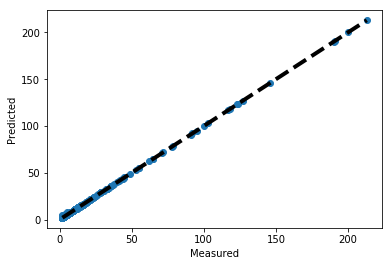

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 10s 6ms/step - loss: 13.1196 - mean_squared_error: 760.0365 - val_loss: 12.7010 - val_mean_squared_error: 2273.8041

Epoch 00001: val_loss did not improve from 0.21840
Epoch 2/50
1618/1618 [==============================] - 2s 1ms/step - loss: 11.2261 - mean_squared_error: 676.4212 - val_loss: 12.4405 - val_mean_squared_error: 2253.7036

Epoch 00002: val_loss did not improve from 0.21840
Epoch 3/50
1618/1618 [==============================] - 2s 2ms/step - loss: 11.0010 - mean_squared_error: 664.6503 - val_loss: 12.2685 - val_mean_squared_error: 2255.2596

Epoch 00003: val_loss did not improve from 0.21840
Epoch 4/50
1618/1618 [==============================] - 2s 2ms/step - loss: 10.8470 - mean_squared_error: 660.2921 - val_loss: 12.1388 - val_mean_squared_error: 2236.2206

Epoch 00004: val_loss did not improve from 0.21840
Epoch 5/50
1618/1618 [==============================] - 2s 2

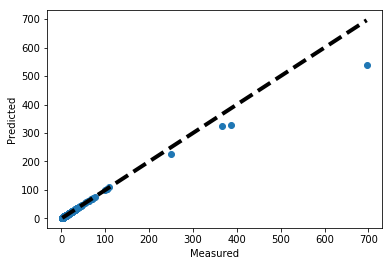

Train on 1618 samples, validate on 405 samples
Epoch 1/50
1618/1618 [==============================] - 10s 6ms/step - loss: 14.0230 - mean_squared_error: 1196.6203 - val_loss: 11.2526 - val_mean_squared_error: 636.0060

Epoch 00001: val_loss did not improve from 0.21840
Epoch 2/50
1618/1618 [==============================] - 2s 1ms/step - loss: 11.5660 - mean_squared_error: 1085.4268 - val_loss: 10.5334 - val_mean_squared_error: 587.3785

Epoch 00002: val_loss did not improve from 0.21840
Epoch 3/50
1618/1618 [==============================] - 2s 2ms/step - loss: 11.4039 - mean_squared_error: 1075.2443 - val_loss: 10.5204 - val_mean_squared_error: 595.9374

Epoch 00003: val_loss did not improve from 0.21840
Epoch 4/50
1618/1618 [==============================] - 2s 2ms/step - loss: 11.3255 - mean_squared_error: 1071.6586 - val_loss: 10.8013 - val_mean_squared_error: 550.7220

Epoch 00004: val_loss did not improve from 0.21840
Epoch 5/50
1618/1618 [==============================] - 2s 2

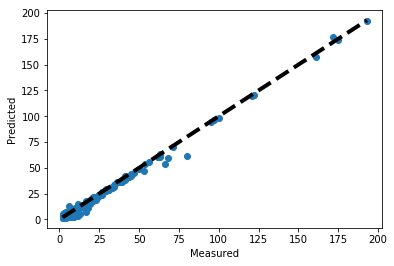

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 11s 7ms/step - loss: 13.9442 - mean_squared_error: 1157.5285 - val_loss: 11.6935 - val_mean_squared_error: 772.6910

Epoch 00001: val_loss did not improve from 0.21840
Epoch 2/50
1619/1619 [==============================] - 2s 2ms/step - loss: 11.8432 - mean_squared_error: 1063.1582 - val_loss: 11.2522 - val_mean_squared_error: 752.1315

Epoch 00002: val_loss did not improve from 0.21840
Epoch 3/50
1619/1619 [==============================] - 3s 2ms/step - loss: 11.6248 - mean_squared_error: 1048.3043 - val_loss: 11.0968 - val_mean_squared_error: 757.3727

Epoch 00003: val_loss did not improve from 0.21840
Epoch 4/50
1619/1619 [==============================] - 3s 2ms/step - loss: 11.4921 - mean_squared_error: 1046.9573 - val_loss: 11.0051 - val_mean_squared_error: 751.4924

Epoch 00004: val_loss did not improve from 0.21840
Epoch 5/50
1619/1619 [==============================] - 3s 2

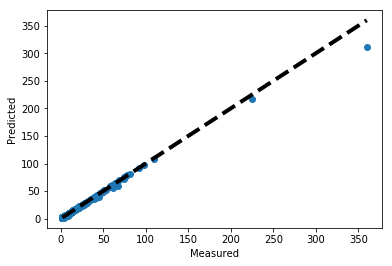

Train on 1619 samples, validate on 404 samples
Epoch 1/50
1619/1619 [==============================] - 11s 7ms/step - loss: 12.9435 - mean_squared_error: 1175.1799 - val_loss: 10.6093 - val_mean_squared_error: 476.5487

Epoch 00001: val_loss did not improve from 0.21840
Epoch 2/50
1619/1619 [==============================] - 3s 2ms/step - loss: 11.8333 - mean_squared_error: 1109.0134 - val_loss: 10.6258 - val_mean_squared_error: 457.0484

Epoch 00002: val_loss did not improve from 0.21840
Epoch 3/50
1619/1619 [==============================] - 2s 2ms/step - loss: 11.6395 - mean_squared_error: 1101.3262 - val_loss: 10.2717 - val_mean_squared_error: 478.7105

Epoch 00003: val_loss did not improve from 0.21840
Epoch 4/50
1619/1619 [==============================] - 2s 2ms/step - loss: 11.5340 - mean_squared_error: 1099.1455 - val_loss: 10.1149 - val_mean_squared_error: 473.6302

Epoch 00004: val_loss did not improve from 0.21840
Epoch 5/50
1619/1619 [==============================] - 2s 2

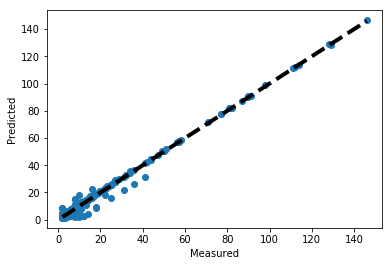

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 64, 64, 16)   448         input_20[0][0]                   
__________________________________________________________________________________________________
activation_291 (Activation)     (None, 64, 64, 16)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 64, 64, 16)   64          activation_291[0][0]             
___________________________________________________________________________________________

In [76]:
model3, model_history3, all_scores3 = evaluateHybrid(images,X,y,imgSize=64)

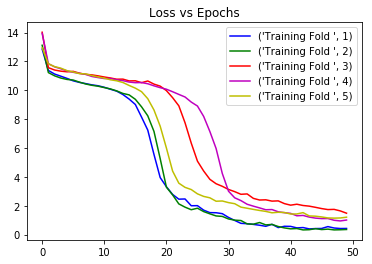

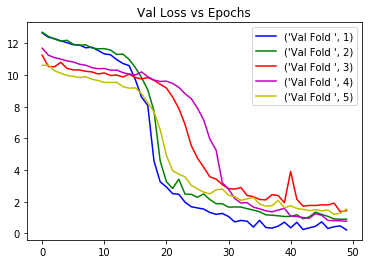

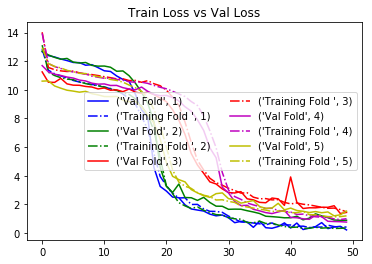

In [77]:
lossTrainPlot(model_history3)
lossValPlot(model_history3)
lossTrainValPlot(model_history3)

In [0]:
def lossKfold3Models(model_history,model_history2,model_history3):
  # plot with various axes scales
  plt.figure(figsize=(20, 10))


  plt.subplot(321)
  plt.plot(model_history[0].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[0].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[0].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('1st Fold')
  plt.grid(True)

  plt.subplot(322)
  plt.plot(model_history[1].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[1].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[1].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('2nd Fold')
  plt.grid(True)

  plt.subplot(323)
  plt.plot(model_history[2].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[2].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[2].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('3rd Fold')
  plt.grid(True)

  plt.subplot(324)
  plt.plot(model_history[3].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[3].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[3].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('4th Fold')
  plt.grid(True)

  plt.subplot(325)
  plt.plot(model_history[4].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[4].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[4].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('5th Fold')
  plt.grid(True)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  plt.savefig('lossKfold3Models.eps', format='eps', dpi=900)

  return plt.show()

In [0]:
def lossKfold3ModelsTransfer(model_historyVGG,model_history2,model_historyRes):
  # plot with various axes scales
  plt.figure(figsize=(20, 10))


  plt.subplot(321)
  plt.plot(model_historyVGG[0].history['loss'], label='VGG19')
  plt.plot(model_history2[0].history['loss'], label='Satellite Imagery')
  plt.plot(model_historyRes[0].history['loss'], label='ResNet50')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('1st Fold')
  plt.grid(True)

  plt.subplot(322)
  plt.plot(model_historyVGG[1].history['loss'], label='VGG19')
  plt.plot(model_history2[1].history['loss'], label='Satellite Imagery')
  plt.plot(model_historyRes[1].history['loss'], label='ResNet50')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('2nd Fold')
  plt.grid(True)

  plt.subplot(323)
  plt.plot(model_historyVGG[2].history['loss'], label='VGG19')
  plt.plot(model_history2[2].history['loss'], label='Satellite Imagery')
  plt.plot(model_historyRes[2].history['loss'], label='ResNet50')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('3rd Fold')
  plt.grid(True)

  plt.subplot(324)
  plt.plot(model_historyVGG[3].history['loss'], label='VGG19')
  plt.plot(model_history2[3].history['loss'], label='Satellite Imagery')
  plt.plot(model_historyRes[3].history['loss'], label='ResNet50')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('4th Fold')
  plt.grid(True)

  plt.subplot(325)
  plt.plot(model_historyVGG[4].history['loss'], label='VGG19')
  plt.plot(model_history2[4].history['loss'], label='Satellite Imagery')
  plt.plot(model_historyRes[4].history['loss'], label='ResNet50')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('5th Fold')
  plt.grid(True)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  plt.savefig('lossKfold3ModelsTransfer.eps', format='eps', dpi=900)

  return plt.show()

In [0]:
def valKfold3Models(model_history,model_history2, model_history3):
  # plot with various axes scales
  plt.figure(figsize=(20, 10))


  plt.subplot(321)
  plt.plot(model_history[0].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[0].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[0].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('1st Fold')
  plt.grid(True)

  plt.subplot(322)
  plt.plot(model_history[1].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[1].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[1].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('2nd Fold')
  plt.grid(True)

  plt.subplot(323)
  plt.plot(model_history[2].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[2].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[2].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('3rd Fold')
  plt.grid(True)

  plt.subplot(324)
  plt.plot(model_history[3].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[3].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[3].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('4th Fold')
  plt.grid(True)

  plt.subplot(325)
  plt.plot(model_history[4].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[4].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[4].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('5th Fold')
  plt.grid(True)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  
  plt.savefig('valKfold3Models.eps', format='eps', dpi=900)

  return plt.show()

In [0]:
def valKfold3ModelsTransfer(model_historyVGG,model_history2, model_historyRes):
  # plot with various axes scales
  plt.figure(figsize=(20, 10))


  plt.subplot(321)
  plt.plot(model_historyVGG[0].history['val_loss'], label='VGG19')
  plt.plot(model_history2[0].history['val_loss'], label='CNN')
  plt.plot(model_historyRes[0].history['val_loss'], label='ResNet50')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('1st Fold')
  plt.grid(True)
  plt.ylim(0,25)

  plt.subplot(322)
  plt.plot(model_historyVGG[1].history['val_loss'], label='VGG19')
  plt.plot(model_history2[1].history['val_loss'], label='CNN')
  plt.plot(model_historyRes[1].history['val_loss'], label='ResNet50')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('2nd Fold')
  plt.grid(True)

  plt.ylim(0,25)

  plt.subplot(323)
  plt.plot(model_historyVGG[2].history['val_loss'], label='VGG19')
  plt.plot(model_history2[2].history['val_loss'], label='CNN')
  plt.plot(model_historyRes[2].history['val_loss'], label='ResNet50')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('3rd Fold')
  plt.grid(True)
  plt.ylim(0,25)

  plt.subplot(324)
  plt.plot(model_historyVGG[3].history['val_loss'], label='VGG19')
  plt.plot(model_history2[3].history['val_loss'], label='CNN')
  plt.plot(model_historyRes[3].history['val_loss'], label='ResNet50')
  plt.ylabel('Validation Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('4th Fold')
  plt.grid(True)
  plt.ylim(0,25)

 
  plt.plot(model_historyVGG[4].history['val_loss'], label='VGG19')
  plt.plot(model_history2[4].history['val_loss'], label='CNN')
  plt.plot(model_historyRes[4].history['val_loss'], label='ResNet50')
  plt.ylabel('Validation Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('5th Fold')
  plt.grid(True)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  
  plt.savefig('valKfold3ModelsTransfer.eps', format='eps', dpi=900)

  plt.ylim(0,25)

  return plt.show()

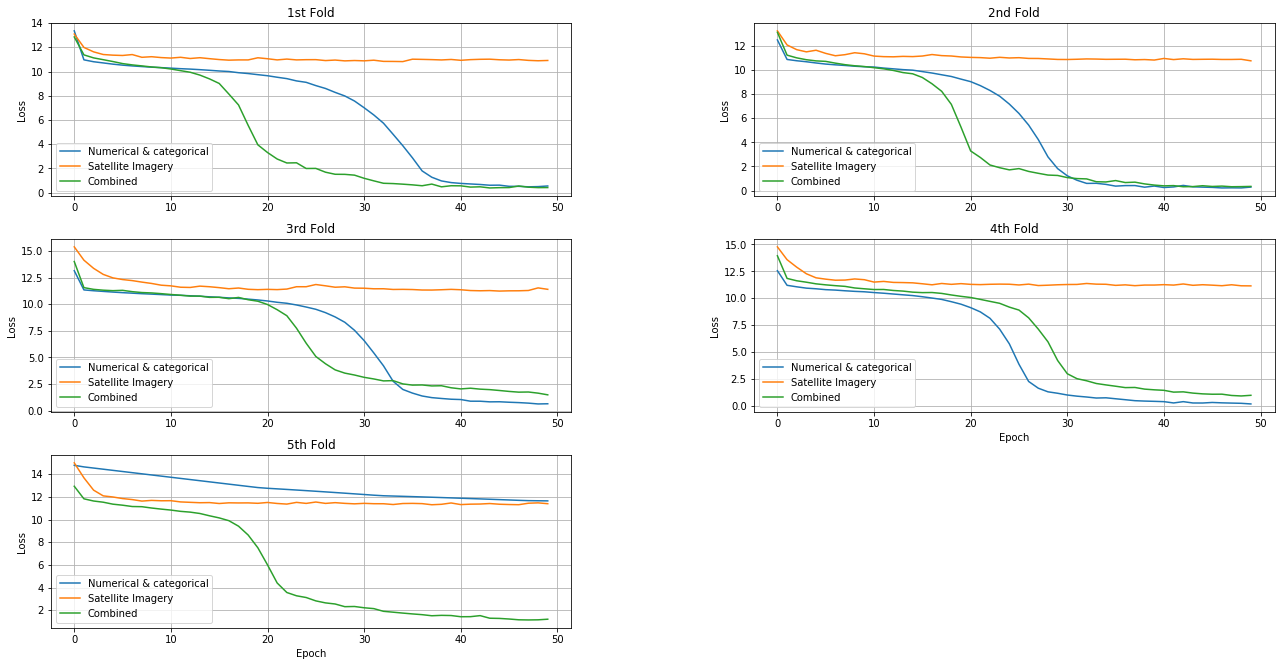

In [84]:
lossKfold3Models(model_history,model_history2,model_history3)

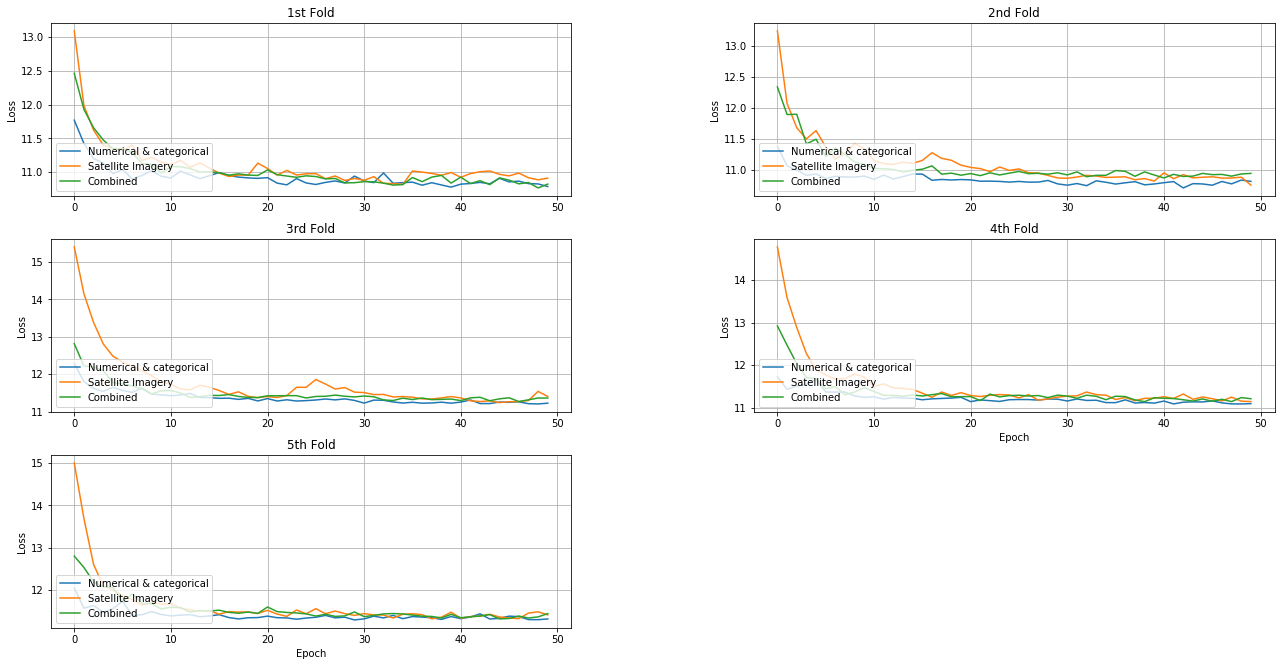

In [85]:
lossKfold3Models(model_historyVGG,model_history2,model_historyRes)

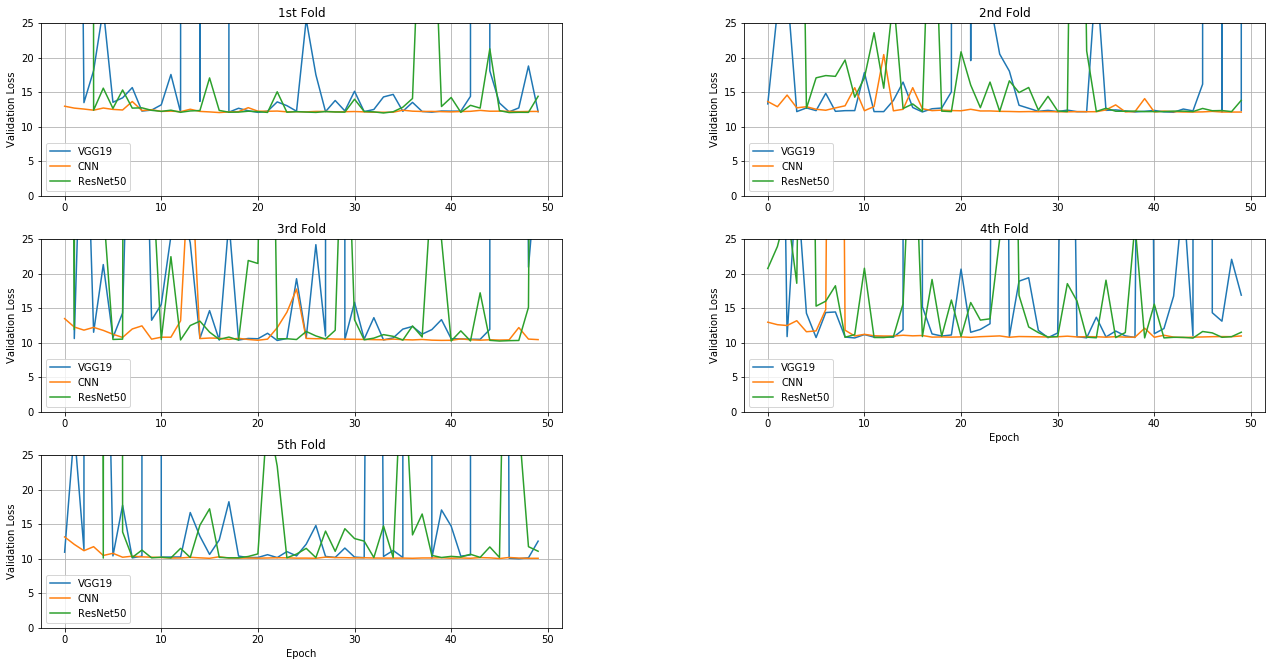

In [68]:
valKfold3ModelsTransfer(model_historyVGG,model_history2, model_historyRes)

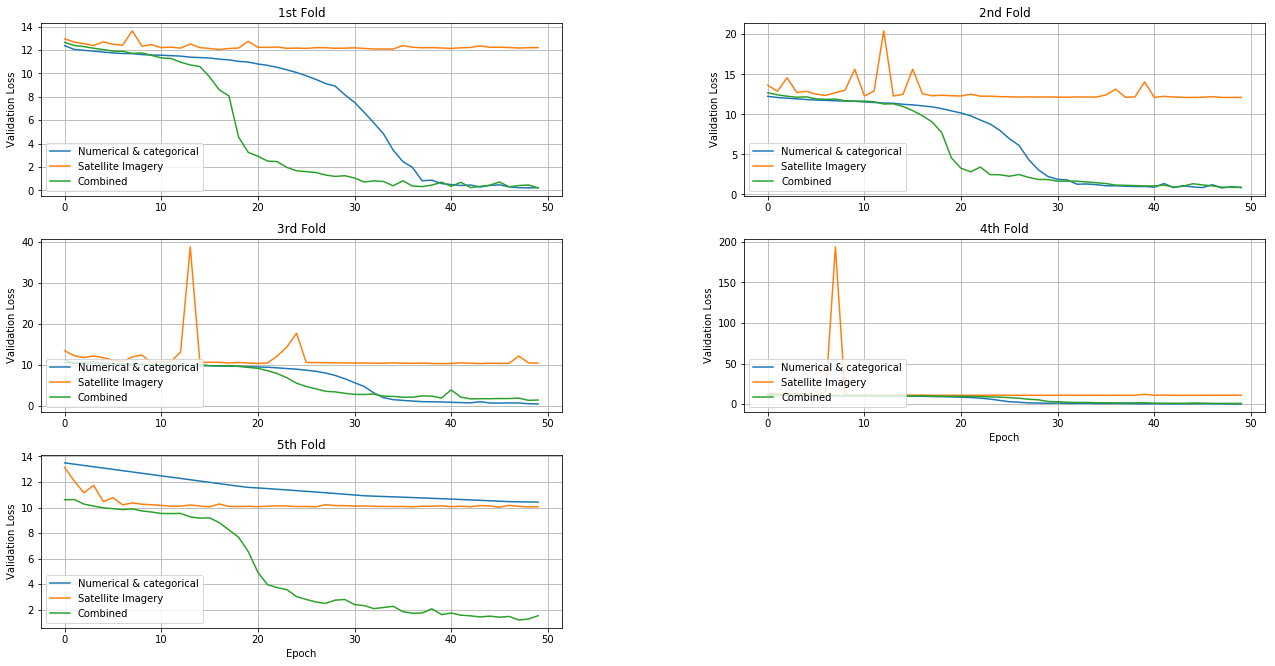

In [87]:
valKfold3Models(model_history,model_history2, model_history3)

In [0]:
def boxPlots3Models(all_scores, all_scores2, all_scores3):

  ax1 = plt.subplot(131)
  plt.boxplot(all_scores)
  plt.title('MLP')
  #plt.ylim(0, 6.5)
  #plt.setp(ax1.get_xticklabels(), fontsize=6)

  # share x only
  ax2 = plt.subplot(132, sharex=ax1)
  plt.boxplot(all_scores2)
  # make these tick labels invisible
  plt.title('CNN')
  plt.setp(ax2.get_xticklabels(), visible=False)

  # share x and y
  ax3 = plt.subplot(133)
  plt.boxplot(all_scores3)
  plt.ylim(0, 2.0)
  plt.title('Hybrid')
  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  plt.savefig('boxPlotsFinal.eps', format='eps', dpi=900)
  plt.show()

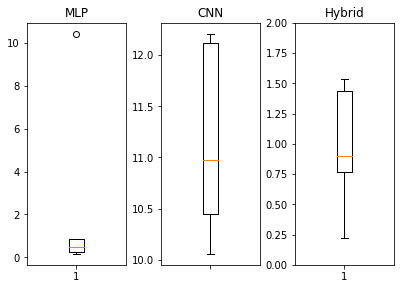

In [91]:
boxPlots3Models(all_scores, all_scores2, all_scores3)

## Sources

Source: 

[1] Cahill, Trey. (2019). Esri Story Maps: Fight the Bite, Protecting Washington, D.C. from Mosquito Borne Disease. 

[2] Giraldo-Calderón GI, Emrich SJ, MacCallum RM, Maslen G, Dialynas E, Topalis P, Ho N, Gesing S, VectorBase Consortium, Madey G, Collins FH, Lawson D. 2015. VectorBase: an updated bioinformatics resource for invertebrate vectors and other organisms related with human diseases. Nucleic Acids Research 43(Database issue):D707-13.

[3] Ehelepola, N. D. B., et al. "A study of the correlation between dengue and weather in Kandy City, Sri Lanka (2003-2012) and lessons learned." Infectious diseases of poverty 4.1 (2015): 42.

H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

https://zoom.earth

In [0]:
'https://wtop.com/health-fitness/2016/06/trap-lab-dc-protects-residents-mosquito-borne-diseases/slide/1/'